<a href="https://colab.research.google.com/github/yatora200403/citrus-orange-disease-detection-20architectures/blob/main/Deteksi_Penyakit_buahjeruk_all_achitecture_batch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the requirements

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import time
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, AveragePooling2D, concatenate, MaxPooling2D, Conv2DTranspose, Input, Conv2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
# !pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syarif200403","key":"e61df152342a40819b97cd7492e87c76"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'jonathansilva2020/orange-diseases-dataset'

Dataset URL: https://www.kaggle.com/datasets/jonathansilva2020/orange-diseases-dataset
License(s): CC-BY-NC-SA-4.0
 83% 114M/138M [00:00<00:00, 1.18GB/s]
100% 138M/138M [00:00<00:00, 1.11GB/s]


<h2>Extract Dataset</h2>

In [ ]:
# Import library untuk handling zip file
import zipfile

In [ ]:
# Spesifikan  nama file
dataset_zip = zipfile.ZipFile('orange-diseases-dataset.zip','r')

# Extract
dataset_zip.extractall('orange-diseases-dataset')

# Tutup zip file
dataset_zip.close()

# Preprocessing

## resize image

In [ ]:
from PIL import Image

# Fungsi untuk memuat dan mengubah ukuran gambar menggunakan PIL
def load_and_resize_image(file_path, target_shape=(224, 224)):
    image = Image.open(file_path).convert('RGB')  # Membuka gambar dan mengonversi ke RGB
    resized_image = image.resize(target_shape)   # Mengubah ukuran gambar
    return np.array(resized_image)               # Mengembalikan gambar dalam bentuk array

In [ ]:
# Fungsi untuk memuat gambar dari direktori
def load_image_class_by_directory(image_dir):
    # Daftar file gambar di dalam direktori
    image_files = [file for file in os.listdir(image_dir) if file.lower().endswith('.jpg') or file.lower().endswith('.png')]
    images = [load_and_resize_image(os.path.join(image_dir, file)) for file in image_files]

    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [ ]:
# Menampilkan beberapa gambar
def display_images(images, num_images_to_display=6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

## change old names and change wrong image format

In [ ]:
# import shutil
# shutil.rmtree('/content/orange-diseases-dataset')

#mengganti nama folder yang tidak sesuai
old_names = ['blackspot', 'canker', 'fresh', 'grenning']
new_names = ['blackspot', 'cancer', 'fresh', 'greening']
train_path = '/content/orange-diseases-dataset/train/'
test_path = '/content/orange-diseases-dataset/test/'
for i,name in enumerate(old_names):
  os.rename(os.path.join(train_path, name), os.path.join(train_path,new_names[i]))
  os.rename(os.path.join(test_path, name), os.path.join(test_path,new_names[i]))

In [ ]:
#convert png to jpg
from PIL import Image

def convert_png_to_jpg(path):
  for filename in os.listdir(path):
    if filename.endswith('.png'):
      img = Image.open(os.path.join(path, filename))
      img = img.convert('RGB')
      img.save(os.path.join(path, os.path.splitext(filename)[0] + '.jpg'))
      os.remove(os.path.join(path, filename))

fresh_train = '/content/orange-diseases-dataset/train/fresh/'
fresh_test = '/content/orange-diseases-dataset/test/fresh/'
convert_png_to_jpg(fresh_train)
convert_png_to_jpg(fresh_test)

Class **1** Sample (Blackspot)

Num of images: 184
Single image shape before flattening: (224, 224, 3)


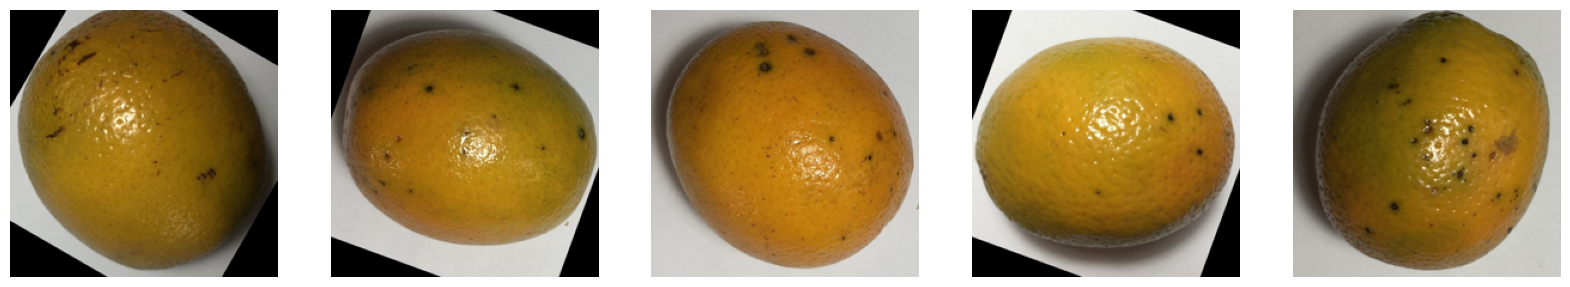

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/blackspot'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 2 Sample (Cancer)

Num of images: 179
Single image shape before flattening: (224, 224, 3)


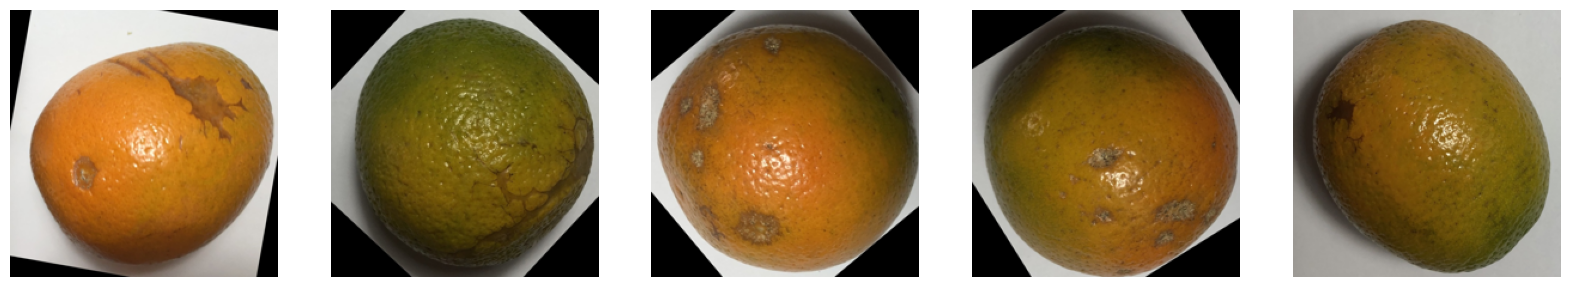

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/cancer'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 3 Sample (Greening)

Num of images: 347
Single image shape before flattening: (224, 224, 3)


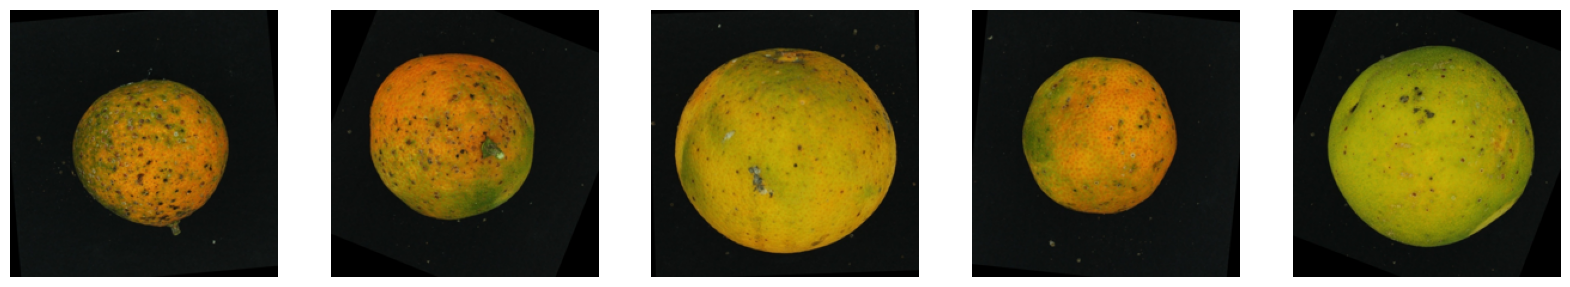

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/greening'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

Class 4 Sample (Fresh)

Num of images: 281
Single image shape before flattening: (224, 224, 3)


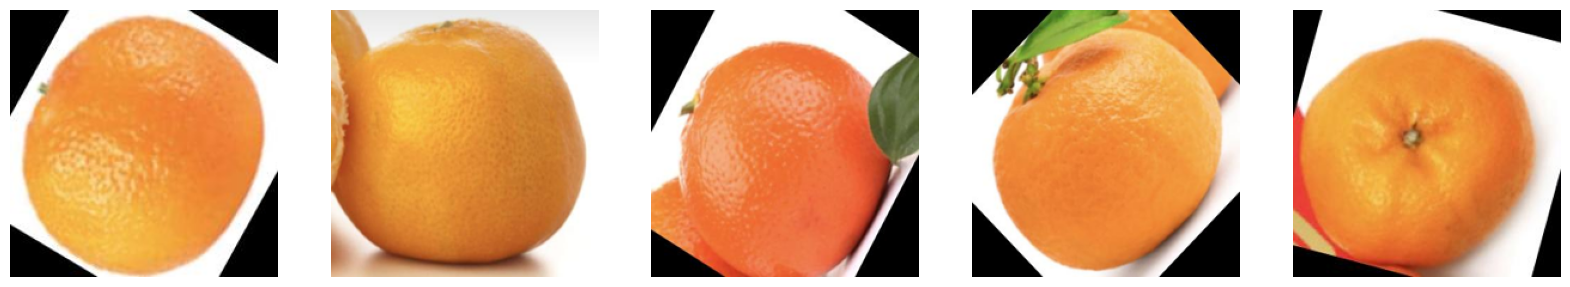

In [ ]:
# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

In [ ]:
def count_images_in_classes(base_dir):
    # Daftar semua subfolder dalam base_dir
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Iterasi untuk menghitung jumlah gambar setiap kelas
    for class_name in class_dirs:
        class_path = os.path.join(base_dir, class_name)
        # Hitung file dengan ekstensi .jpg atau .png
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith('.jpg') or f.lower().endswith('.png')])
        print(f"Disease: {class_name} --- Images: {num_images}")

# Path menuju direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

count_images_in_classes(base_dir)

Disease: blackspot --- Images: 184
Disease: fresh --- Images: 281
Disease: greening --- Images: 347
Disease: cancer --- Images: 179


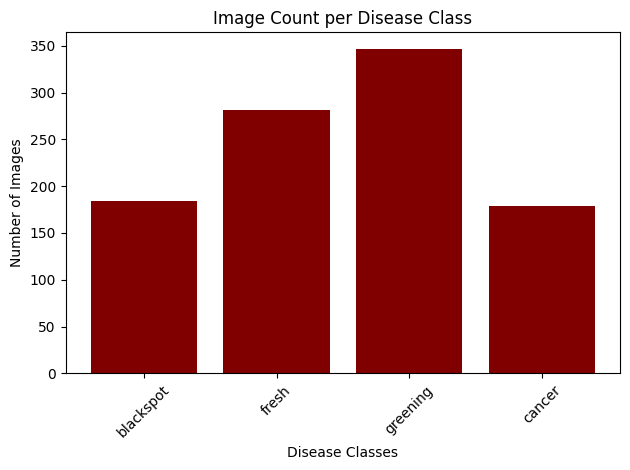

In [ ]:
def count_images_and_plot(base_dir):
    # Hitung jumlah gambar per kelas
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    class_counts = [len([f for f in os.listdir(os.path.join(base_dir, d)) if f.lower().endswith('.jpg') or f.lower().endswith('.png')]) for d in class_dirs]

    # Buat chart
    plt.bar(class_dirs, class_counts, color='maroon')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.title('Image Count per Disease Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path menuju ke direktori dataset
base_dir = '/content/orange-diseases-dataset/train'

# Hitung dan juga tampilkan chart
count_images_and_plot(base_dir)

## Data Augmentation

In [ ]:
def image_aug(path, img_class:str):
  img_list = []
  for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_list.append(img_array)


  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True
  )

  for img in img_list:
    img = img.reshape((1,) + img.shape)
    for batch in datagen.flow(img, batch_size=1, save_to_dir='/content/orange-diseases-dataset/train/'+img_class, save_prefix=img_class, save_format='jpg'):
      if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
        break
    if len(os.listdir('/content/orange-diseases-dataset/train/'+img_class)) == 500:
      break

disease_classes = ['blackspot','cancer','greening','fresh']
for disease in disease_classes:
  image_aug('/content/orange-diseases-dataset/train/'+disease, disease)

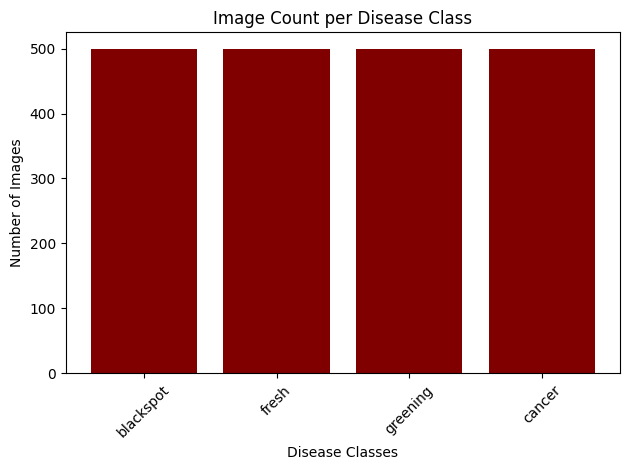

In [ ]:
count_images_and_plot(base_dir)
# plt.imshow(Image.open('/content/orange-diseases-dataset/train/blackspot/blackspot_0_150.jpg'))
# plt.axis('off')
# plt.show()

## Image Normalization

Found 2000 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Num of images: 500
Single image shape before flattening: (224, 224, 3)


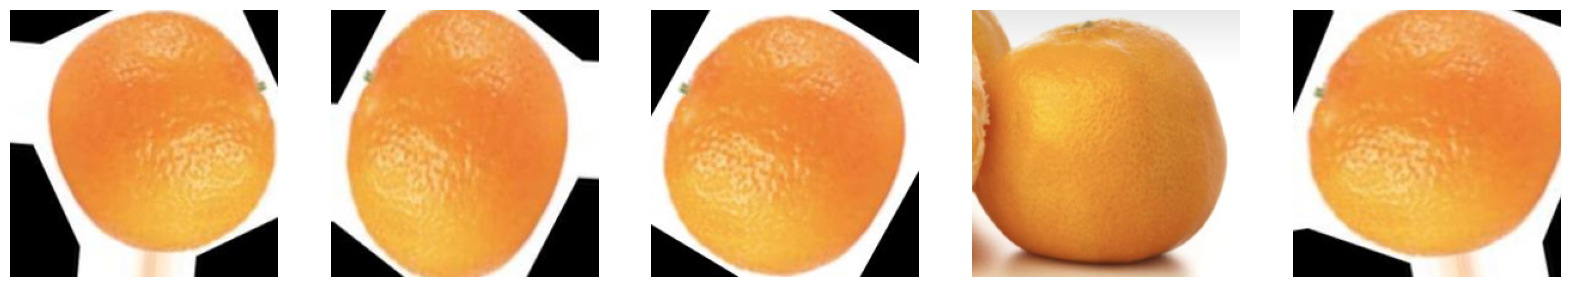

In [ ]:
datagen_normalized = ImageDataGenerator(rescale=1./255)

train_generator_normalized = datagen_normalized.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator_normalized = datagen_normalized.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Path menuju direktori kelas gambar
image_dir = '/content/orange-diseases-dataset/train/fresh'

# Memuat gambar dari direktori
images = load_image_class_by_directory(image_dir)

# Menampilkan beberapa gambar
display_images(images, num_images_to_display=5)

## Splitting Dataset into:

<ul>
  <li>training = 70%</li>
  <li>validation = 15%</li>
  <li>test = 15%</li>
</ul>

In [ ]:
dataset_path = Path('/content/orange-diseases-dataset/train')
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
#store all name of disease class names
class_names = train_ds.class_names

# Further split the validation dataset to create a test dataset
val_batches = int(0.5 * val_ds.cardinality().numpy())
valid_ds = val_ds.take(val_batches)
test_ds = val_ds.skip(val_batches)

# Print dataset information
print(f"Training batches: {train_ds.cardinality().numpy()}")
print(f"Validation batches: {valid_ds.cardinality().numpy()}")
print(f"Testing batches: {test_ds.cardinality().numpy()}")


Found 2000 files belonging to 4 classes.
Using 1400 files for training.
Found 2000 files belonging to 4 classes.
Using 600 files for validation.
Training batches: 44
Validation batches: 9
Testing batches: 10


# Training Process

## 1. ResNet101V2

In [ ]:
from tensorflow.keras.applications import ResNet101V2

base_model_resnet101v2 = ResNet101V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_resnet101v2.trainable = False

model_resnet101v2 = tf.keras.Sequential([
    base_model_resnet101v2,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_resnet101v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_resnet101v2.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 2048)           │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,200,708 (164.80 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 42,630,656 (162.62 MB)

In [ ]:
starttime_resnet101v2 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_resnet101v2 = model_resnet101v2.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_resnet101v2 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 488ms/step - accuracy: 0.5551 - loss: 1.0120 - val_accuracy: 0.5278 - val_loss: 1.2975
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.8874 - loss: 0.3368 - val_accuracy: 0.6250 - val_loss: 0.7868
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9188 - loss: 0.2269 - val_accuracy: 0.8819 - val_loss: 0.2987
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9322 - loss: 0.1803 - val_accuracy: 0.9201 - val_loss: 0.1952
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9402 - loss: 0.1367 - val_accuracy: 0.9271 - val_loss: 0.1512
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9508 - loss: 0.1196 - val_accuracy: 0.9201 - val_loss: 0.1392
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9565 - loss: 0.1096 - val_accuracy: 0.9479 - val_loss: 0.1120
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9524 - loss: 0.1063 - val_accurac

## 2. ResNet152

In [ ]:
from tensorflow.keras.applications import ResNet152

base_model_resnet152 = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_resnet152.trainable = False

model_resnet152 = tf.keras.Sequential([
    base_model_resnet152,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_resnet152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_resnet152.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 2048)           │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,945,092 (224.86 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 58,375,040 (222.68 MB)

In [ ]:
starttime_resnet152 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_resnet152 = model_resnet152.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_resnet152 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 720ms/step - accuracy: 0.6769 - loss: 0.8633 - val_accuracy: 0.8958 - val_loss: 0.4508
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 269ms/step - accuracy: 0.9514 - loss: 0.1587 - val_accuracy: 0.9514 - val_loss: 0.1999
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.9800 - loss: 0.0753 - val_accuracy: 0.9896 - val_loss: 0.0916
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.9926 - loss: 0.0402 - val_accuracy: 0.9931 - val_loss: 0.0564
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.9851 - loss: 0.0509 - val_accuracy: 0.9896 - val_loss: 0.0585
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.9940 - loss: 0.0232 - val_accuracy: 0.9896 - val_loss: 0.0400
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.9901 - loss: 0.0242 - val_accuracy: 0.9931 - val_loss: 0.0382
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.9969 - loss: 0.0151 - val_accu

## 3. ResNet152V2

In [ ]:
from tensorflow.keras.applications import ResNet152V2

base_model_resnet152v2 = ResNet152V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_resnet152v2.trainable = False

model_resnet152v2 = tf.keras.Sequential([
    base_model_resnet152v2,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_resnet152v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_resnet152v2.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,905,796 (224.71 MB)

 Trainable params: 570,052 (2.17 MB)

 Non-trainable params: 58,335,744 (222.53 MB)

In [ ]:
starttime_resnet152v2 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_resnet152v2 = model_resnet152v2.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_resnet152v2 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 610ms/step - accuracy: 0.5677 - loss: 0.9780 - val_accuracy: 0.4549 - val_loss: 2.4016
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8645 - loss: 0.3787 - val_accuracy: 0.7083 - val_loss: 0.6785
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.9106 - loss: 0.2404 - val_accuracy: 0.8715 - val_loss: 0.3245
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.9253 - loss: 0.2132 - val_accuracy: 0.9236 - val_loss: 0.2055
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.9279 - loss: 0.1807 - val_accuracy: 0.9479 - val_loss: 0.1249
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.9216 - loss: 0.1885 - val_accuracy: 0.9306 - val_loss: 0.1556
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9426 - loss: 0.1508 - val_accuracy: 0.9271 - val_loss: 0.1631
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9411 - loss: 0.1454 - val_accura

## 4. EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model_efficientnetb0 = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_efficientnetb0.trainable = False

model_efficientnetb0 = tf.keras.Sequential([
    base_model_efficientnetb0,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_efficientnetb0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_efficientnetb0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,424,039 (16.88 MB)

 Trainable params: 371,908 (1.42 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
starttime_efficientnetb0 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_efficientnetb0 = model_efficientnetb0.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_efficientnetb0 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 489ms/step - accuracy: 0.6144 - loss: 1.0172 - val_accuracy: 0.8924 - val_loss: 0.7818
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9606 - loss: 0.1710 - val_accuracy: 0.9792 - val_loss: 0.4198
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9794 - loss: 0.0880 - val_accuracy: 0.9861 - val_loss: 0.2539
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9859 - loss: 0.0609 - val_accuracy: 0.9792 - val_loss: 0.1544
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9914 - loss: 0.0432 - val_accuracy: 0.9965 - val_loss: 0.0894
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9866 - loss: 0.0488 - val_accuracy: 0.9826 - val_loss: 0.0663
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9896 - loss: 0.0402 - val_accuracy: 0.9826 - val_loss: 0.0622
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9911 - loss: 0.0324 - val_accuracy: 0.9

## 5.EfficientNetV2B0

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

base_model_efficientnetv2b0 = EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_efficientnetv2b0.trainable = False

model_efficientnetv2b0 = tf.keras.Sequential([
    base_model_efficientnetv2b0,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_efficientnetv2b0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_efficientnetv2b0.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,293,780 (24.01 MB)

 Trainable params: 371,908 (1.42 MB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
starttime_efficientnetv2b0 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_efficientnetv2b0 = model_efficientnetv2b0.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_efficientnetv2b0 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 541ms/step - accuracy: 0.5565 - loss: 1.1142 - val_accuracy: 0.9444 - val_loss: 0.8262
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9626 - loss: 0.2516 - val_accuracy: 0.9757 - val_loss: 0.4716
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9712 - loss: 0.1228 - val_accuracy: 0.9826 - val_loss: 0.2658
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9751 - loss: 0.0846 - val_accuracy: 0.9965 - val_loss: 0.1561
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9917 - loss: 0.0434 - val_accuracy: 0.9965 - val_loss: 0.0839
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9902 - loss: 0.0394 - val_accuracy: 0.9965 - val_loss: 0.0585
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9914 - loss: 0.0386 - val_accuracy: 0.9965 - val_loss: 0.0379
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9897 - loss: 0.0351 - val_accuracy: 0.9931 

## 6. EfficientNetB7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

base_model_efficientnetb7 = EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model_efficientnetb7.trainable = False

model_efficientnetb7 = tf.keras.Sequential([
    base_model_efficientnetb7,
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_efficientnetb7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_efficientnetb7.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,804,955 (247.21 MB)

 Trainable params: 702,148 (2.68 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

In [ ]:
starttime_efficientnetb7 = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history_efficientnetb7 = model_efficientnetb7.fit(train_ds,
                    epochs=50,
                    validation_data=valid_ds,
                    callbacks=early_stopping)
endtime_efficientnetb7 = time.time()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5990 - loss: 0.9688 - val_accuracy: 0.7465 - val_loss: 1.0304
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.9206 - loss: 0.2444 - val_accuracy: 0.8924 - val_loss: 0.7393
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - accuracy: 0.9564 - loss: 0.1429 - val_accuracy: 0.9340 - val_loss: 0.5245
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.9567 - loss: 0.1133 - val_accuracy: 0.9688 - val_loss: 0.3461
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.9698 - loss: 0.0841 - val_accuracy: 0.9722 - val_loss: 0.2361
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - accuracy: 0.9721 - loss: 0.0781 - val_accuracy: 0.9931 - val_loss: 0.1336
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.9855 - loss: 0.0525 - val_accuracy: 0.9965 - val_loss: 0.0766
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.9842 - loss: 0.0504 - val_accura

# Training Performace

In [ ]:
number_of_architecture = 6
number_of_column = 2
number_of_row = int(number_of_architecture / number_of_column)
recall_list = []
precision_list = []
f1score_list = []
trainingtime_list = []
accuracy_list = []
val_accuracy_list = []
loss_list = []
val_loss_list = []
epochs_list = []

## training and validation performance

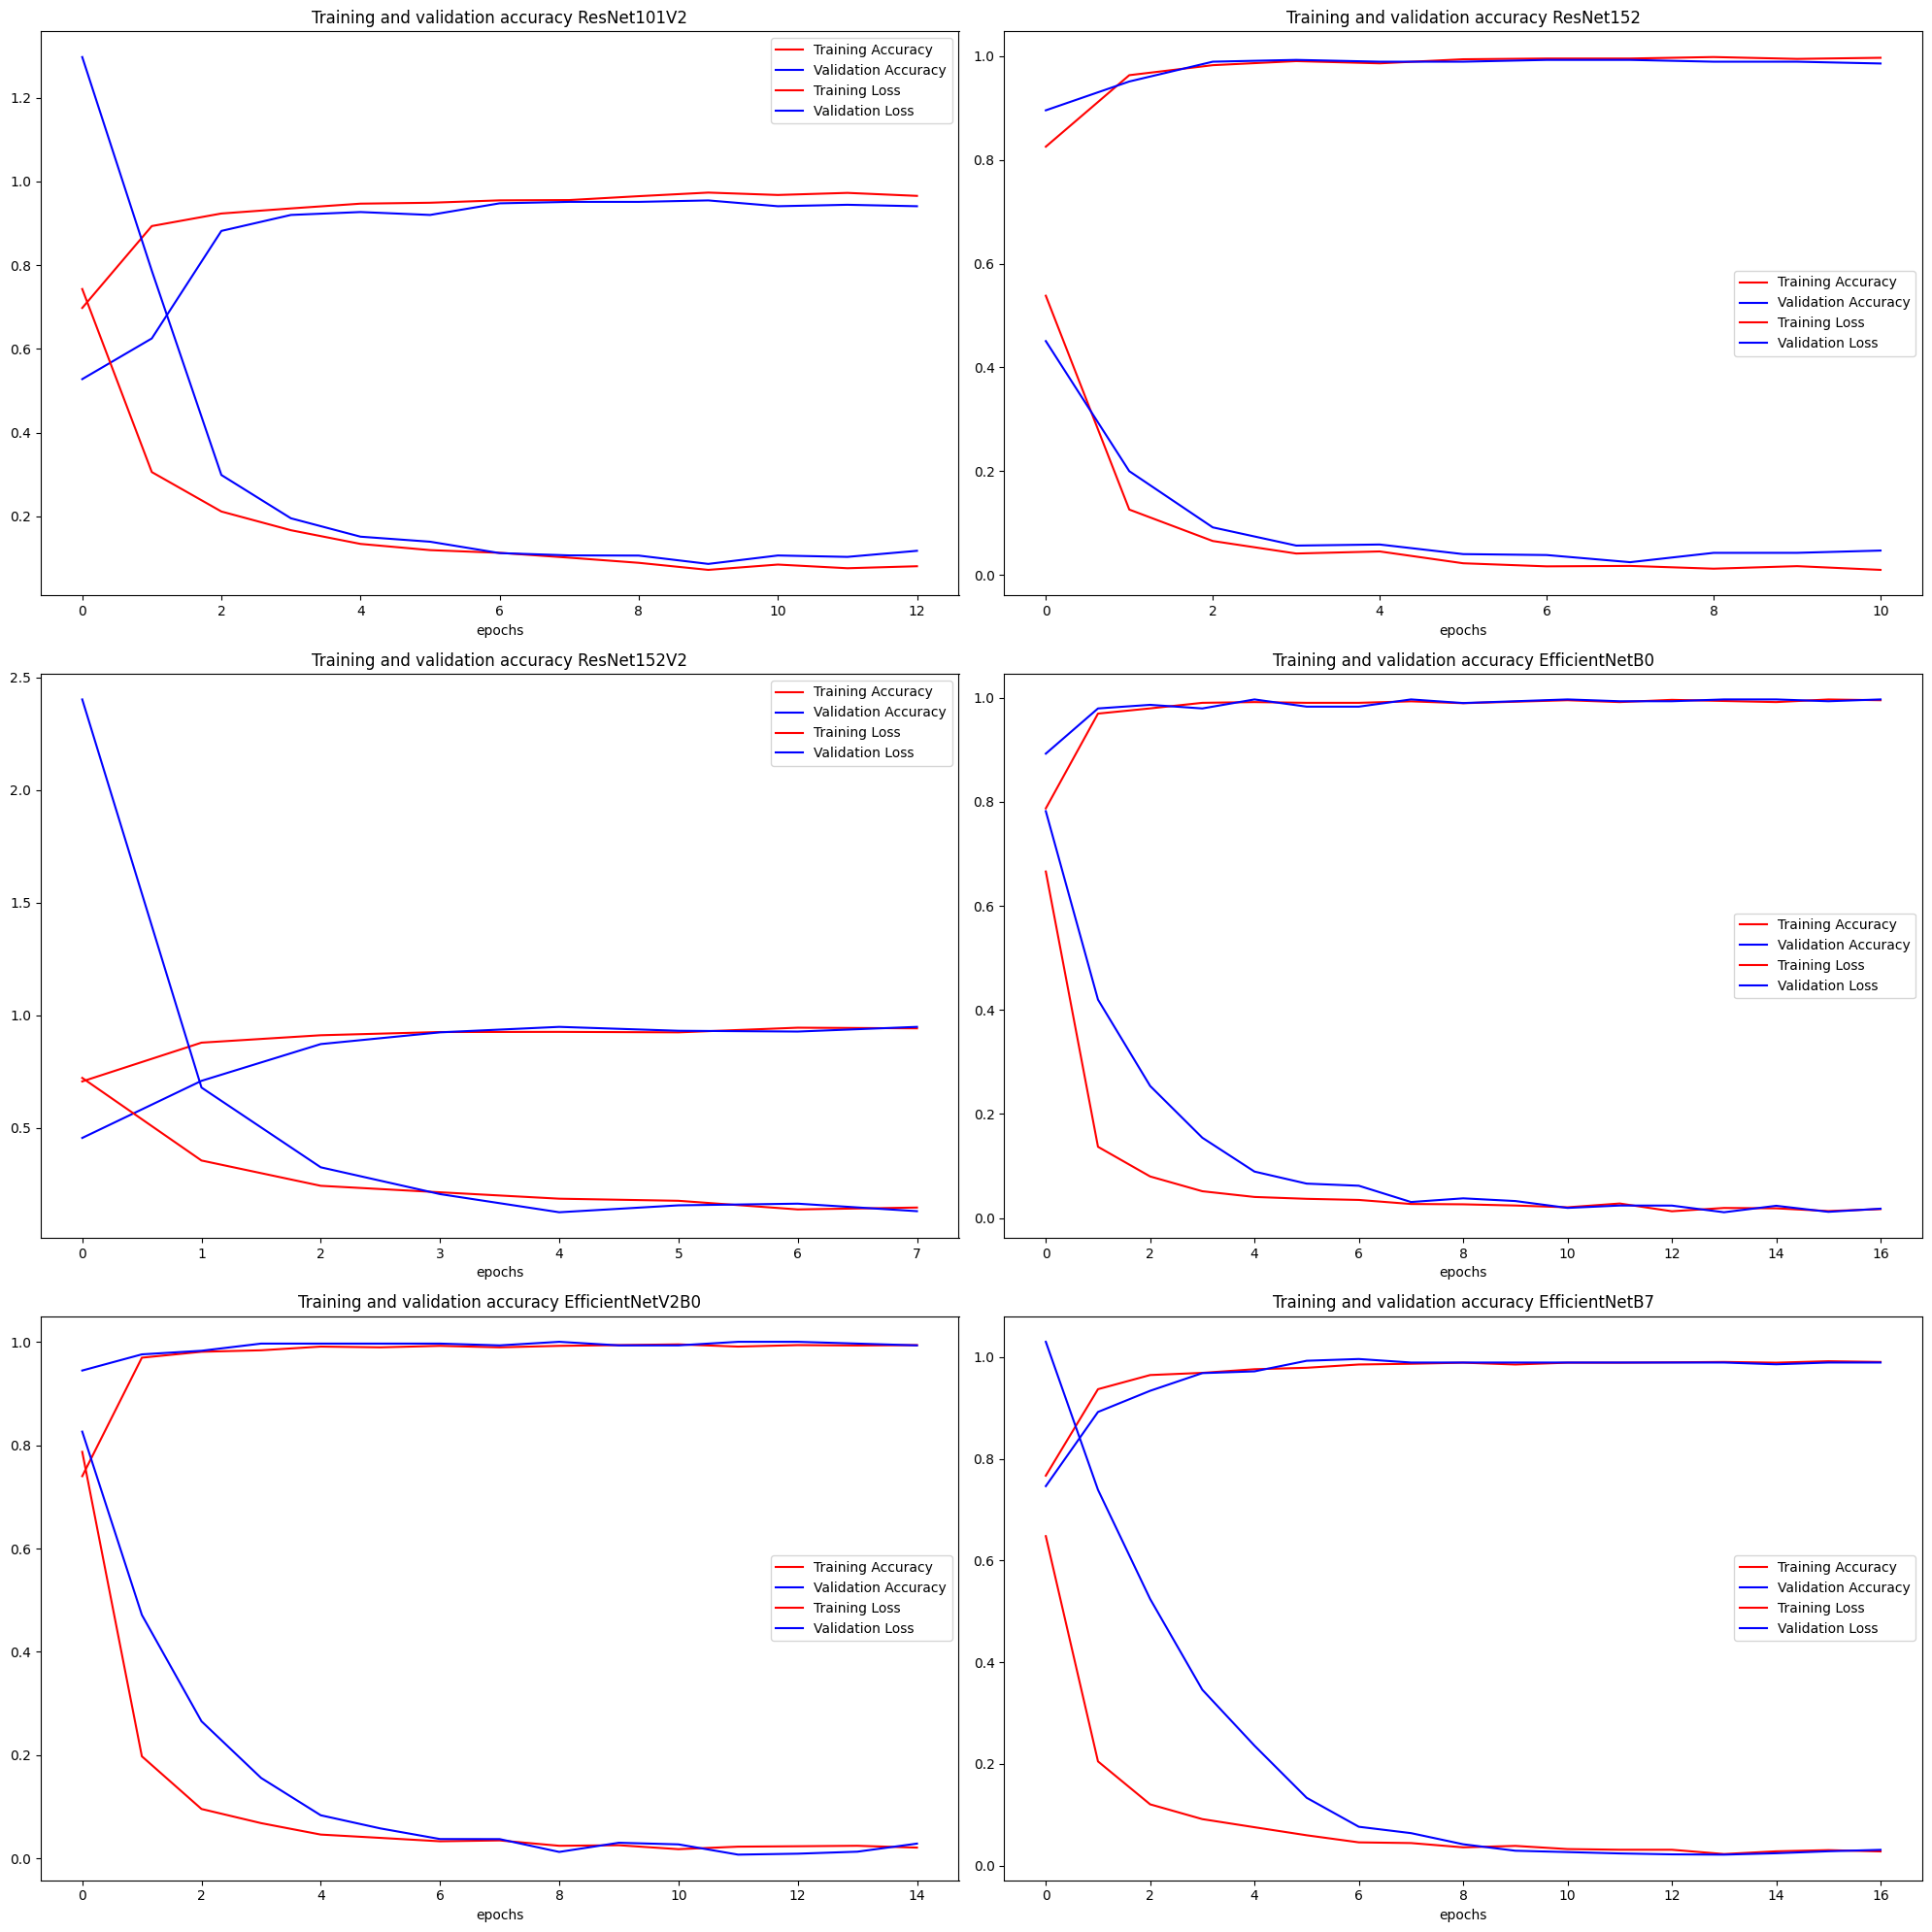

In [ ]:
fig, axes = plt.subplots(number_of_row, number_of_column, figsize=(20,20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

## ResNet101V2
# Get training and validation accuracies
acc = history_resnet101v2.history['accuracy']
val_acc = history_resnet101v2.history['val_accuracy']
loss = history_resnet101v2.history['loss']
val_loss = history_resnet101v2.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[0].set_title('Training and validation accuracy ResNet101V2')
axes[0].plot(epochs, acc, 'r', label="Training Accuracy")
axes[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[0].plot(epochs, loss, 'r', label="Training Loss")
axes[0].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[0].legend()
axes[0].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## ResNet152
# Get training and validation accuracies
acc = history_resnet152.history['accuracy']
val_acc = history_resnet152.history['val_accuracy']
loss = history_resnet152.history['loss']
val_loss = history_resnet152.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[1].set_title('Training and validation accuracy ResNet152')
axes[1].plot(epochs, acc, 'r', label="Training Accuracy")
axes[1].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[1].plot(epochs, loss, 'r', label="Training Loss")
axes[1].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[1].legend()
axes[1].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## ResNet152V2
# Get training and validation accuracies
acc = history_resnet152v2.history['accuracy']
val_acc = history_resnet152v2.history['val_accuracy']
loss = history_resnet152v2.history['loss']
val_loss = history_resnet152v2.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[2].set_title('Training and validation accuracy ResNet152V2')
axes[2].plot(epochs, acc, 'r', label="Training Accuracy")
axes[2].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[2].plot(epochs, loss, 'r', label="Training Loss")
axes[2].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[2].legend()
axes[2].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## EfficientNetB0
# Get training and validation accuracies
acc = history_efficientnetb0.history['accuracy']
val_acc = history_efficientnetb0.history['val_accuracy']
loss = history_efficientnetb0.history['loss']
val_loss = history_efficientnetb0.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[3].set_title('Training and validation accuracy EfficientNetB0')
axes[3].plot(epochs, acc, 'r', label="Training Accuracy")
axes[3].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[3].plot(epochs, loss, 'r', label="Training Loss")
axes[3].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[3].legend()
axes[3].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## EfficientNetV2B0
# Get training and validation accuracies
acc = history_efficientnetv2b0.history['accuracy']
val_acc = history_efficientnetv2b0.history['val_accuracy']
loss = history_efficientnetv2b0.history['loss']
val_loss = history_efficientnetv2b0.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[4].set_title('Training and validation accuracy EfficientNetV2B0')
axes[4].plot(epochs, acc, 'r', label="Training Accuracy")
axes[4].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[4].plot(epochs, loss, 'r', label="Training Loss")
axes[4].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[4].legend()
axes[4].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

## EfficientNetB7
# Get training and validation accuracies
acc = history_efficientnetb7.history['accuracy']
val_acc = history_efficientnetb7.history['val_accuracy']
loss = history_efficientnetb7.history['loss']
val_loss = history_efficientnetb7.history['val_loss']
# Get number of epochs
epochs = range(len(acc))
axes[5].set_title('Training and validation accuracy EfficientNetB7')
axes[5].plot(epochs, acc, 'r', label="Training Accuracy")
axes[5].plot(epochs, val_acc, 'b', label="Validation Accuracy")
axes[5].plot(epochs, loss, 'r', label="Training Loss")
axes[5].plot(epochs, val_loss, 'b', label="Validation Loss")
axes[5].legend()
axes[5].set_xlabel('epochs')
accuracy_list.append(acc)
val_accuracy_list.append(val_acc)
loss_list.append(loss)
val_loss_list.append(val_loss)
epochs_list.append(epochs)

plt.tight_layout()
plt.show()

###alternative

In [ ]:
# # Get training and validation accuracies
# acc = history_mobilenetv3large.history['accuracy']
# val_acc = history_mobilenetv3large.history['val_accuracy']
# loss = history_mobilenetv3large.history['loss']
# val_loss = history_mobilenetv3large.history['val_loss']
# # Get number of epochs
# epochs = range(len(acc))
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Training and validation accuracy MobileNetV3Large')
# for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
#     ax[i].plot(epochs, data[0], 'r', label="Training " + label)
#     ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
#     ax[i].legend()
#     ax[i].set_xlabel('epochs')
# plt.show()

## y_true and y_pred

In [ ]:
# ResNet101V2
print("ResNet101V2")
y_true_resnet101v2 = []
y_pred_resnet101v2 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_resnet101v2.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_resnet101v2.extend(true_labels)
    y_pred_resnet101v2.extend(predicted_labels)

# ResNet152
print("ResNet152")
y_true_resnet152 = []
y_pred_resnet152 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_resnet152.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_resnet152.extend(true_labels)
    y_pred_resnet152.extend(predicted_labels)

# ResNet152V2
print("ResNet152V2")
y_true_resnet152v2 = []
y_pred_resnet152v2 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_resnet152v2.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_resnet152v2.extend(true_labels)
    y_pred_resnet152v2.extend(predicted_labels)

# EfficientNetB0
print("EfficientNetB0")
y_true_efficientnetb0 = []
y_pred_efficientnetb0 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_efficientnetb0.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_efficientnetb0.extend(true_labels)
    y_pred_efficientnetb0.extend(predicted_labels)

# EfficientNetV2B0
print("EfficientNetV2B0")
y_true_efficientnetv2b0 = []
y_pred_efficientnetv2b0 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_efficientnetv2b0.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_efficientnetv2b0.extend(true_labels)
    y_pred_efficientnetv2b0.extend(predicted_labels)

# EfficientNetB7
print("EfficientNetB7")
y_true_efficientnetb7 = []
y_pred_efficientnetb7 = []
for images, labels in test_ds:
    true_labels = labels.numpy()
    predictions = model_efficientnetb7.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_efficientnetb7.extend(true_labels)
    y_pred_efficientnetb7.extend(predicted_labels)

ResNet101V2
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
ResNet152
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
ResNet152V2
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/

## training time

In [ ]:
# ResNet101V2 Training
trainingtime_resnet101v2 = endtime_resnet101v2 - starttime_resnet101v2
print(f"ResNet101V2 training time: {trainingtime_resnet101v2:.2f} seconds")
trainingtime_list.append(trainingtime_resnet101v2)

print("-" * 10)

# ResNet152 Training
trainingtime_resnet152 = endtime_resnet152 - starttime_resnet152
print(f"ResNet152 training time: {trainingtime_resnet152:.2f} seconds")
trainingtime_list.append(trainingtime_resnet152)

print("-" * 10)

# ResNet152V2 Training
trainingtime_resnet152v2 = endtime_resnet152v2 - starttime_resnet152v2
print(f"ResNet152V2 training time: {trainingtime_resnet152v2:.2f} seconds")
trainingtime_list.append(trainingtime_resnet152v2)

print("-" * 10)

# EfficientNetB0 Training
trainingtime_efficientnetb0 = endtime_efficientnetb0 - starttime_efficientnetb0
print(f"EfficientNetB0 training time: {trainingtime_efficientnetb0:.2f} seconds")
trainingtime_list.append(trainingtime_efficientnetb0)

print("-" * 10)

# EfficientNetV2B0 Training
trainingtime_efficientnetv2b0 = endtime_efficientnetv2b0 - starttime_efficientnetv2b0
print(f"EfficientNetV2B0 training time: {trainingtime_efficientnetv2b0:.2f} seconds")
trainingtime_list.append(trainingtime_efficientnetv2b0)

print("-" * 10)

# EfficientNetB7 Training
trainingtime_efficientnetb7 = endtime_efficientnetb7 - starttime_efficientnetb7
print(f"EfficientNetB7 training time: {trainingtime_efficientnetb7:.2f} seconds")
trainingtime_list.append(trainingtime_efficientnetb7)

ResNet101V2 training time: 151.74 seconds
----------
ResNet152 training time: 305.29 seconds
----------
ResNet152V2 training time: 122.28 seconds
----------
EfficientNetB0 training time: 124.24 seconds
----------
EfficientNetV2B0 training time: 116.14 seconds
----------
EfficientNetB7 training time: 443.76 seconds


## Recall

In [ ]:
# ResNet101V2
print("ResNet101V2")
test_loss, test_acc = model_resnet101v2.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# ResNet152
print("ResNet152")
test_loss, test_acc = model_resnet152.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# ResNet152V2
print("ResNet152V2")
test_loss, test_acc = model_resnet152v2.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# EfficientNetB0
print("EfficientNetB0")
test_loss, test_acc = model_efficientnetb0.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# EfficientNetV2B0
print("EfficientNetV2B0")
test_loss, test_acc = model_efficientnetv2b0.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

print("-" * 10)

# EfficientNetB7
print("EfficientNetB7")
test_loss, test_acc = model_efficientnetb7.evaluate(train_ds)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
recall_list.append([test_acc, test_loss])

ResNet101V2
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.9821 - loss: 0.0485
Test Accuracy: 0.9835714101791382
Test Loss: 0.046574920415878296
----------
ResNet152
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 295ms/step - accuracy: 0.9968 - loss: 0.0093
Test Accuracy: 0.9985714554786682
Test Loss: 0.007572961039841175
----------
ResNet152V2
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.9379 - loss: 0.1412
Test Accuracy: 0.9385714530944824
Test Loss: 0.1409512609243393
----------
EfficientNetB0
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9963 - loss: 0.0124
Test Accuracy: 0.9985714554786682
Test Loss: 0.007209933828562498
----------
EfficientNetV2B0
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9961 - loss: 0.0130
Test Accuracy: 0.9964285492897034
Test Loss: 0.010041894391179085
----------
EfficientNetB7
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9953 - loss: 0.0127
Test Accuracy: 0.9957143068313599
Test Loss: 0.011238631792366505


## Precission

In [ ]:
# ResNet101V2
precision = precision_score(y_true_resnet101v2, y_pred_resnet101v2, average='weighted')
print(f"Precision ResNet101V2: {precision}")
precision_list.append(precision)

print("-" * 10)

# ResNet152
precision = precision_score(y_true_resnet152, y_pred_resnet152, average='weighted')
print(f"Precision ResNet152: {precision}")
precision_list.append(precision)

print("-" * 10)

# ResNet152V2
precision = precision_score(y_true_resnet152v2, y_pred_resnet152v2, average='weighted')
print(f"Precision ResNet152V2: {precision}")
precision_list.append(precision)

print("-" * 10)

# EfficientNetB0
precision = precision_score(y_true_efficientnetb0, y_pred_efficientnetb0, average='weighted')
print(f"Precision EfficientNetB0: {precision}")
precision_list.append(precision)

print("-" * 10)

# EfficientNetV2B0
precision = precision_score(y_true_efficientnetv2b0, y_pred_efficientnetv2b0, average='weighted')
print(f"Precision EfficientNetV2B0: {precision}")
precision_list.append(precision)

print("-" * 10)

# EfficientNetB7
precision = precision_score(y_true_efficientnetb7, y_pred_efficientnetb7, average='weighted')
print(f"Precision EfficientNetB7: {precision}")
precision_list.append(precision)

Precision ResNet101V2: 0.9284188034188033
----------
Precision ResNet152: 0.9935897435897436
----------
Precision ResNet152V2: 0.9319234809838534
----------
Precision EfficientNetB0: 0.9937562437562437
----------
Precision EfficientNetV2B0: 0.9937678062678063
----------
Precision EfficientNetB7: 0.9968376068376068


## F1-score

In [ ]:
# ResNet101V2
f1 = f1_score(y_true_resnet101v2, y_pred_resnet101v2, average='weighted')
print(f"F1 Score ResNet101V2: {f1}")
f1score_list.append(f1)

print("-" * 10)

# ResNet152
f1 = f1_score(y_true_resnet152, y_pred_resnet152, average='weighted')
print(f"F1 Score ResNet152: {f1}")
f1score_list.append(f1)

print("-" * 10)

# ResNet152V2
f1 = f1_score(y_true_resnet152v2, y_pred_resnet152v2, average='weighted')
print(f"F1 Score ResNet152V2: {f1}")
f1score_list.append(f1)

print("-" * 10)

# EfficientNetB0
f1 = f1_score(y_true_efficientnetb0, y_pred_efficientnetb0, average='weighted')
print(f"F1 Score EfficientNetB0: {f1}")
f1score_list.append(f1)

print("-" * 10)

# EfficientNetV2B0
f1 = f1_score(y_true_efficientnetv2b0, y_pred_efficientnetv2b0, average='weighted')
print(f"F1 Score EfficientNetV2B0: {f1}")
f1score_list.append(f1)

print("-" * 10)

# EfficientNetB7
f1 = f1_score(y_true_efficientnetb7, y_pred_efficientnetb7, average='weighted')
print(f"F1 Score EfficientNetB7: {f1}")
f1score_list.append(f1)

F1 Score ResNet101V2: 0.9195599445599445
----------
F1 Score ResNet152: 0.9935897435897436
----------
F1 Score ResNet152V2: 0.9322696404633039
----------
F1 Score EfficientNetB0: 0.9935913450861819
----------
F1 Score EfficientNetV2B0: 0.9935943149974172
----------
F1 Score EfficientNetB7: 0.9967950142513456


## Confusion matrix

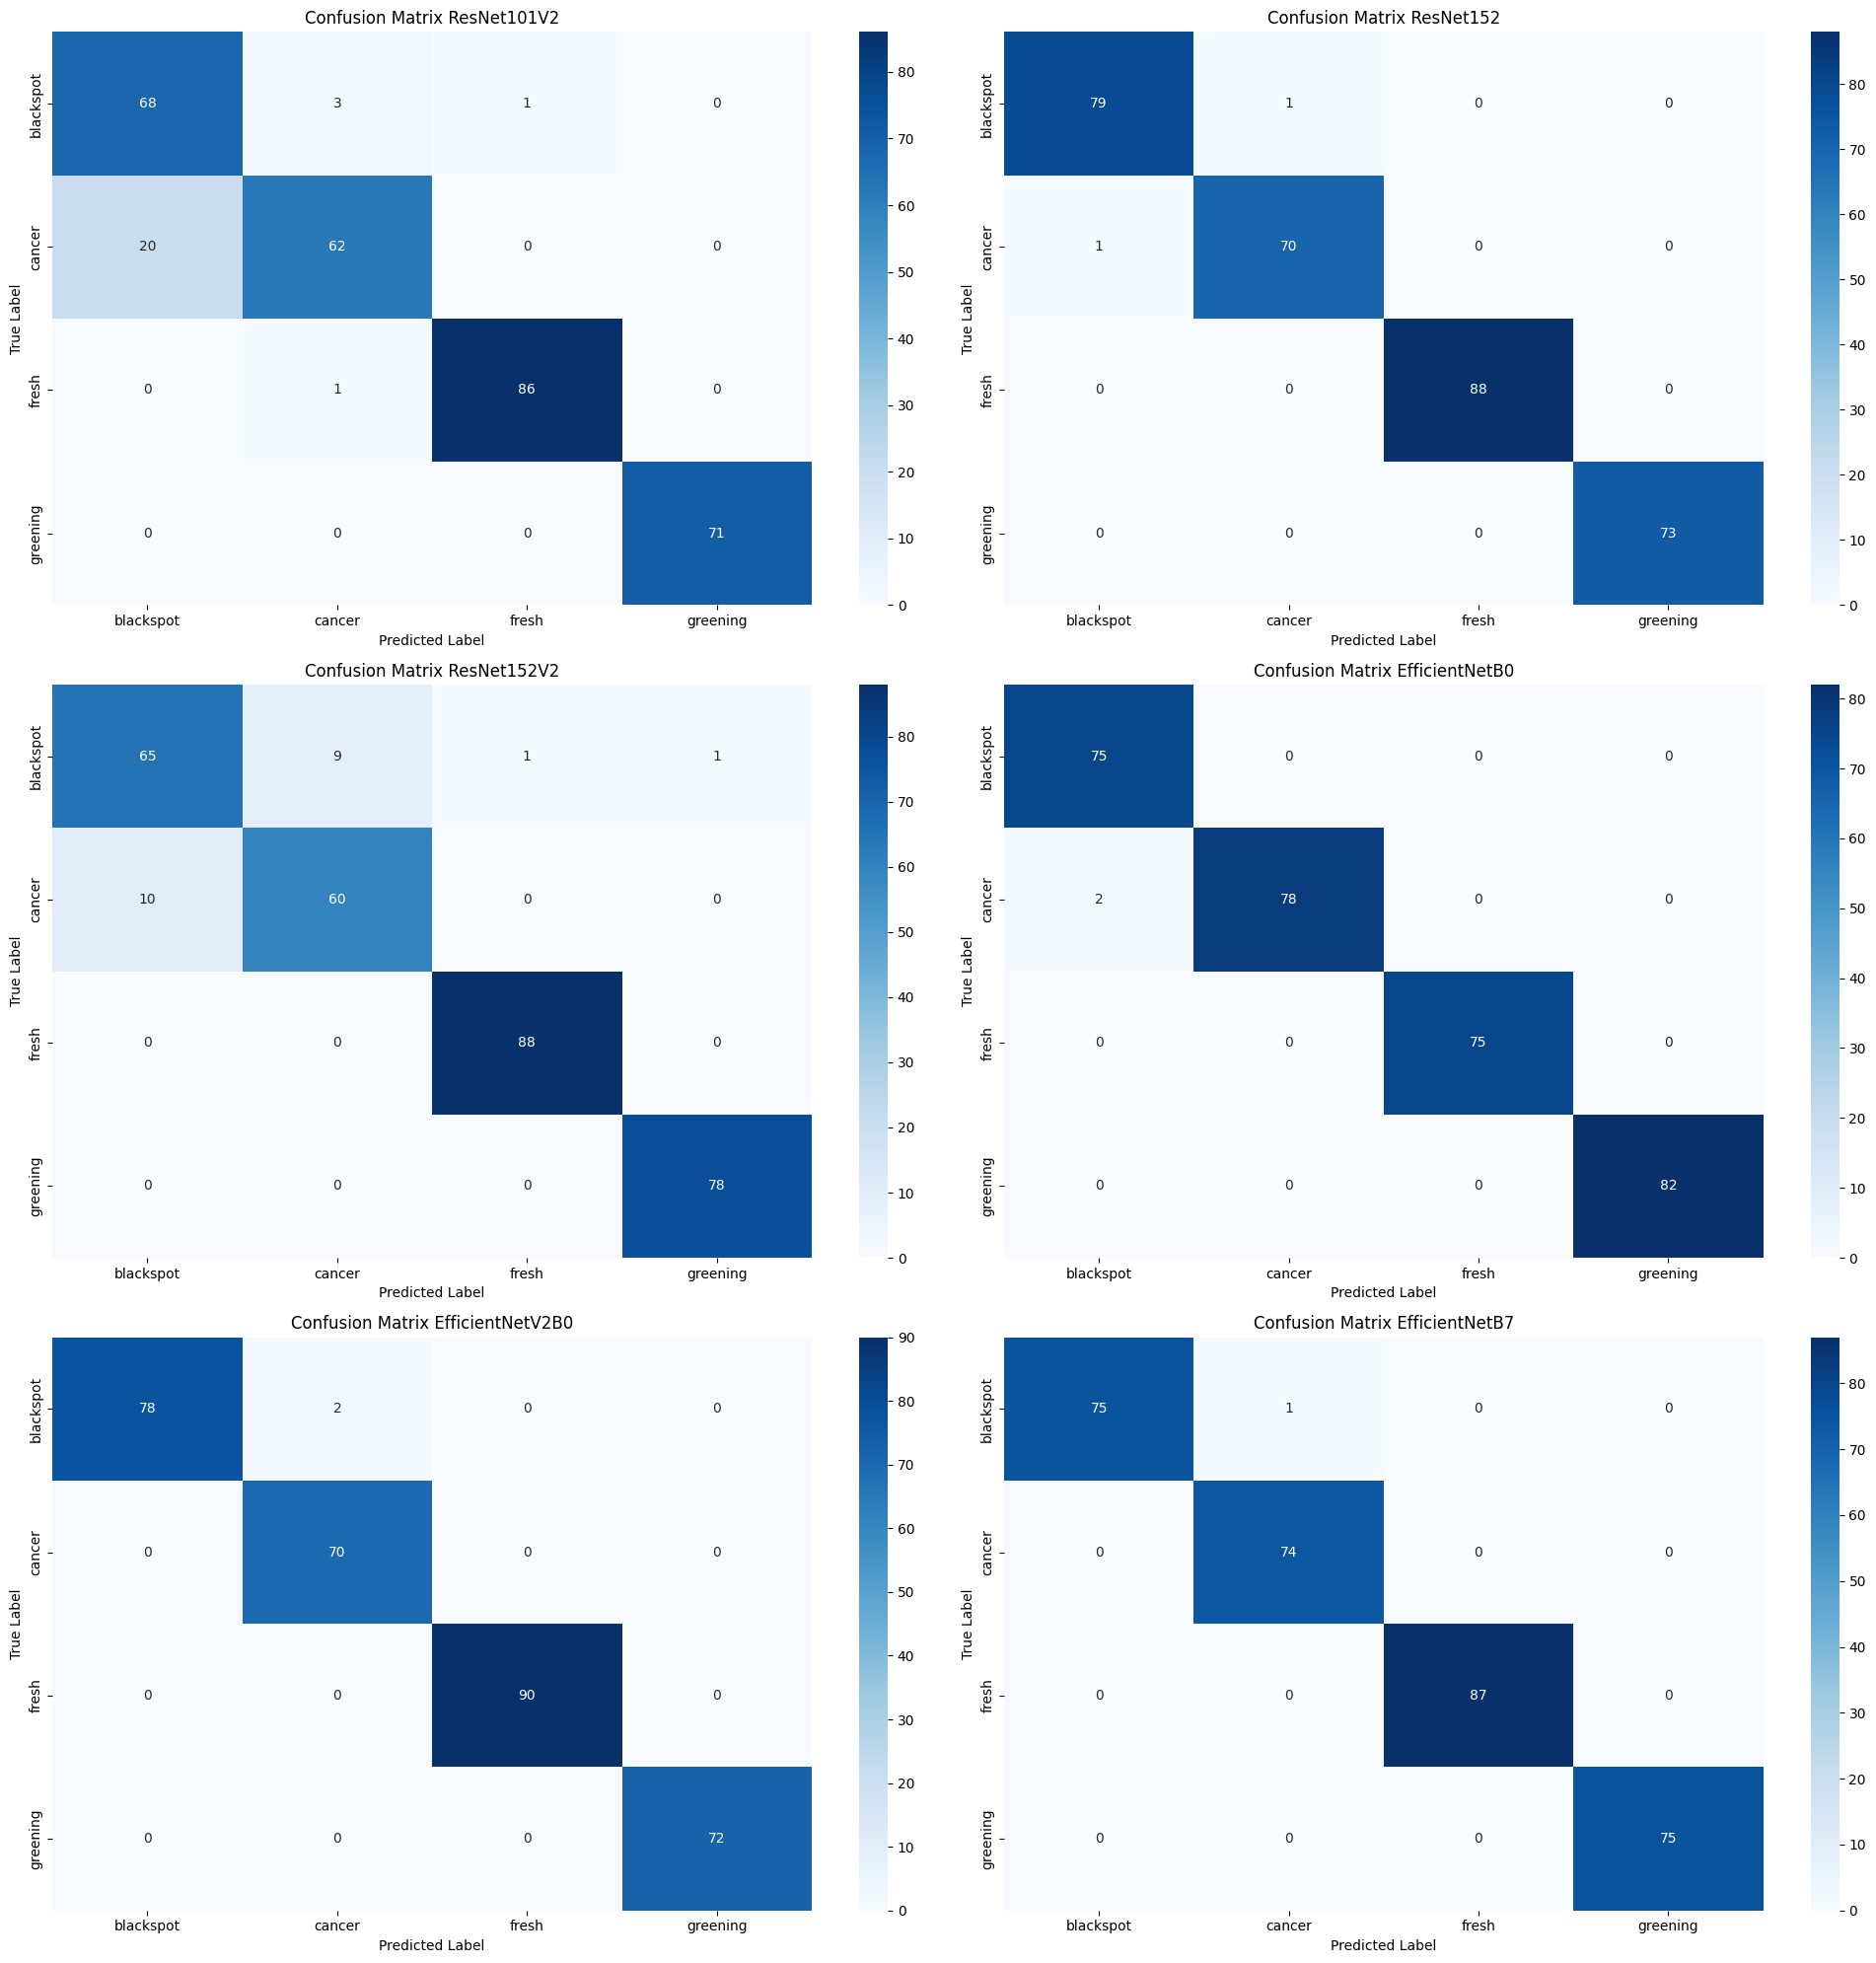

In [ ]:
## All architecture subplot
fig, axes = plt.subplots(number_of_row, number_of_column, figsize=(20, 20))

axes = axes.flatten()

## ResNet101V2
cm = confusion_matrix(y_true_resnet101v2, y_pred_resnet101v2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix ResNet101V2')

## ResNet152
cm = confusion_matrix(y_true_resnet152, y_pred_resnet152)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix ResNet152')

## ResNet152V2
cm = confusion_matrix(y_true_resnet152v2, y_pred_resnet152v2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('Confusion Matrix ResNet152V2')

## EfficientNetB0
cm = confusion_matrix(y_true_efficientnetb0, y_pred_efficientnetb0)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[3])
axes[3].set_xlabel('Predicted Label')
axes[3].set_ylabel('True Label')
axes[3].set_title('Confusion Matrix EfficientNetB0')

## EfficientNetV2B0
cm = confusion_matrix(y_true_efficientnetv2b0, y_pred_efficientnetv2b0)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[4])
axes[4].set_xlabel('Predicted Label')
axes[4].set_ylabel('True Label')
axes[4].set_title('Confusion Matrix EfficientNetV2B0')

## EfficientNetB7
cm = confusion_matrix(y_true_efficientnetb7, y_pred_efficientnetb7)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[5])
axes[5].set_xlabel('Predicted Label')
axes[5].set_ylabel('True Label')
axes[5].set_title('Confusion Matrix EfficientNetB7')

fig.tight_layout()
plt.show()

## test case

Testing with image: /content/orange-diseases-dataset/test/greening/g (2).jpg


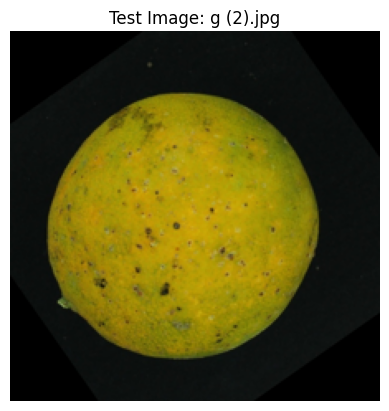



ResNet101V2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 0
Predicted label: blackspot
----------
ResNet152:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 2
Predicted label: fresh
----------
ResNet152V2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 3
Predicted label: greening
----------
EfficientNetB0:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class index: 2
Predicted label: fresh
----------
EfficientNetV2B0:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 2
Predicted label: fresh
----------
EfficientNetB7:
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class index: 3
Predicted label: greening


In [ ]:
# Select one image from the test folder
test_dir = '/content/orange-diseases-dataset/test/'
# Get a list of all subdirectories (disease classes) in the test directory
disease_classes_test = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

if not disease_classes_test:
    print("No disease class subdirectories found in the test directory.")
else:
    # Choose the first disease class found (you can modify this to choose a specific class)
    chosen_disease_class = disease_classes_test[2]
    chosen_class_path = os.path.join(test_dir, chosen_disease_class)

    # Get a list of all files in the chosen disease class directory
    image_files = [f for f in os.listdir(chosen_class_path) if f.lower().endswith(('.jpg', '.png'))]

    if not image_files:
        print(f"No images found in the directory: {chosen_class_path}")
    else:
        # Choose the first image file found (you can modify this to choose a specific image)
        test_image_path = os.path.join(chosen_class_path, image_files[0])
        print(f"Testing with image: {test_image_path}")

        # Load and preprocess the image
        img = load_and_resize_image(test_image_path)
        img_array = np.expand_dims(img, axis=0) / 255.0

        # Display the test image
        plt.imshow(img)
        plt.title(f"Test Image: {os.path.basename(test_image_path)}")
        plt.axis('off')
        plt.show()

        # Make predictions with each model
        print("\n")
        # ResNet101V2
        print("ResNet101V2:")
        predictions_resnet101v2 = model_resnet101v2.predict(img_array)
        predicted_class_resnet101v2 = np.argmax(predictions_resnet101v2, axis=1)[0]
        predicted_label_resnet101v2 = class_names[predicted_class_resnet101v2]
        print(f"Predicted class index: {predicted_class_resnet101v2}")
        print(f"Predicted label: {predicted_label_resnet101v2}")

        print("-" * 10)

        # ResNet152
        print("ResNet152:")
        predictions_resnet152 = model_resnet152.predict(img_array)
        predicted_class_resnet152 = np.argmax(predictions_resnet152, axis=1)[0]
        predicted_label_resnet152 = class_names[predicted_class_resnet152]
        print(f"Predicted class index: {predicted_class_resnet152}")
        print(f"Predicted label: {predicted_label_resnet152}")

        print("-" * 10)

        # ResNet152V2
        print("ResNet152V2:")
        predictions_resnet152v2 = model_resnet152v2.predict(img_array)
        predicted_class_resnet152v2 = np.argmax(predictions_resnet152v2, axis=1)[0]
        predicted_label_resnet152v2 = class_names[predicted_class_resnet152v2]
        print(f"Predicted class index: {predicted_class_resnet152v2}")
        print(f"Predicted label: {predicted_label_resnet152v2}")

        print("-" * 10)

        # EfficientNetB0
        print("EfficientNetB0:")
        predictions_efficientnetb0 = model_efficientnetb0.predict(img_array)
        predicted_class_efficientnetb0 = np.argmax(predictions_efficientnetb0, axis=1)[0]
        predicted_label_efficientnetb0 = class_names[predicted_class_efficientnetb0]
        print(f"Predicted class index: {predicted_class_efficientnetb0}")
        print(f"Predicted label: {predicted_label_efficientnetb0}")

        print("-" * 10)

        # EfficientNetV2B0
        print("EfficientNetV2B0:")
        predictions_efficientnetv2b0 = model_efficientnetv2b0.predict(img_array)
        predicted_class_efficientnetv2b0 = np.argmax(predictions_efficientnetv2b0, axis=1)[0]
        predicted_label_efficientnetv2b0 = class_names[predicted_class_efficientnetv2b0]
        print(f"Predicted class index: {predicted_class_efficientnetv2b0}")
        print(f"Predicted label: {predicted_label_efficientnetv2b0}")

        print("-" * 10)

        # EfficientNetB7
        print("EfficientNetB7:")
        predictions_efficientnetb7 = model_efficientnetb7.predict(img_array)
        predicted_class_efficientnetb7 = np.argmax(predictions_efficientnetb7, axis=1)[0]
        predicted_label_efficientnetb7 = class_names[predicted_class_efficientnetb7]
        print(f"Predicted class index: {predicted_class_efficientnetb7}")
        print(f"Predicted label: {predicted_label_efficientnetb7}")

## Performance Table

In [ ]:
import pandas as pd
import numpy as np

# Function to get trainable and non-trainable parameters
def get_model_params(model):
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    return trainable_params, non_trainable_params

# Extracting the number of epochs the model was actually trained for (due to early stopping)
epochs_resnet101v2 = len(history_resnet101v2.history['accuracy'])
epochs_resnet152 = len(history_resnet152.history['accuracy'])
epochs_resnet152v2 = len(history_resnet152v2.history['accuracy'])
epochs_efficientnetb0 = len(history_efficientnetb0.history['accuracy'])
epochs_efficientnetv2b0 = len(history_efficientnetv2b0.history['accuracy'])
epochs_efficientnetb7 = len(history_efficientnetb7.history['accuracy'])


# Get trainable and non-trainable parameters for each model
trainable_resnet101v2, non_trainable_resnet101v2 = get_model_params(model_resnet101v2)
trainable_resnet152, non_trainable_resnet152 = get_model_params(model_resnet152)
trainable_resnet152v2, non_trainable_resnet152v2 = get_model_params(model_resnet152v2)
trainable_efficientnetb0, non_trainable_efficientnetb0 = get_model_params(model_efficientnetb0)
trainable_efficientnetv2b0, non_trainable_efficientnetv2b0 = get_model_params(model_efficientnetv2b0)
trainable_efficientnetb7, non_trainable_efficientnetb7 = get_model_params(model_efficientnetb7)

# Create the DataFrame
data = {
    'Architecture': ['resnet101v2', 'resnet152', 'resnet152v2', 'efficientnetb0', 'efficientnetv2b0', 'efficientnetb7'],
    'Epochs': [epochs_resnet101v2, epochs_resnet152, epochs_resnet152v2, epochs_efficientnetb0, epochs_efficientnetv2b0, epochs_efficientnetb7],
    'Trainable Param': [trainable_resnet101v2, trainable_resnet152, trainable_resnet152v2, trainable_efficientnetb0, trainable_efficientnetv2b0, trainable_efficientnetb7],
    'Non-trainable Param': [non_trainable_resnet101v2, non_trainable_resnet152, non_trainable_resnet152v2, non_trainable_efficientnetb0, non_trainable_efficientnetv2b0, non_trainable_efficientnetb7],
    'Training Time (s)': trainingtime_list,
    'Acc': [history_resnet101v2.history['accuracy'][-1], history_resnet152.history['accuracy'][-1], history_resnet152v2.history['accuracy'][-1], history_efficientnetb0.history['accuracy'][-1], history_efficientnetv2b0.history['accuracy'][-1], history_efficientnetb7.history['accuracy'][-1]],
    'Val_Acc': [history_resnet101v2.history['val_accuracy'][-1], history_resnet152.history['val_accuracy'][-1], history_resnet152v2.history['val_accuracy'][-1], history_efficientnetb0.history['val_accuracy'][-1], history_efficientnetv2b0.history['val_accuracy'][-1], history_efficientnetb7.history['val_accuracy'][-1]],
    'Loss': [history_resnet101v2.history['loss'][-1], history_resnet152.history['loss'][-1], history_resnet152v2.history['loss'][-1], history_efficientnetb0.history['loss'][-1], history_efficientnetv2b0.history['loss'][-1], history_efficientnetb7.history['loss'][-1]],
    'Val_Loss': [history_resnet101v2.history['val_loss'][-1], history_resnet152.history['val_loss'][-1], history_resnet152v2.history['val_loss'][-1], history_efficientnetb0.history['val_loss'][-1], history_efficientnetv2b0.history['val_loss'][-1], history_efficientnetb7.history['val_loss'][-1]],
    'Recall': [recall_list[0][0], recall_list[1][0], recall_list[2][0], recall_list[3][0], recall_list[4][0], recall_list[5][0]],
    'Precision': precision_list,
    'F1-score': f1score_list
}

df_performance = pd.DataFrame(data)
df_performance['Training Time (s)'] = df_performance['Training Time (s)'].round(2)
df_performance['Acc'] = df_performance['Acc'].round(4)
df_performance['Val_Acc'] = df_performance['Val_Acc'].round(4)
df_performance['Loss'] = df_performance['Loss'].round(4)
df_performance['Val_Loss'] = df_performance['Val_Loss'].round(4)
df_performance['Recall'] = df_performance['Recall'].round(4)
df_performance['Precision'] = df_performance['Precision'].round(4)
df_performance['F1-score'] = df_performance['F1-score'].round(4)


df_performance.head(6)

,Architecture,Epochs,Trainable Param,Non-trainable Param,Training Time (s),Acc,Val_Acc,Loss,Val_Loss,Recall,Precision,F1-score
0,resnet101v2,13,570052,42630656.0,151.74,0.9657,0.9410,0.0806,0.1175,0.9836,0.9284,0.9196
1,resnet152,11,570052,58375040.0,305.29,0.9971,0.9861,0.0096,0.0468,0.9986,0.9936,0.9936
2,resnet152v2,8,570052,58335744.0,122.28,0.9414,0.9479,0.1458,0.1297,0.9386,0.9319,0.9323
3,efficientnetb0,17,371908,4052131.0,124.24,0.9950,0.9965,0.0173,0.0181,0.9986,0.9938,0.9936
4,efficientnetv2b0,15,371908,5921872.0,116.14,0.9936,0.9931,0.0213,0.0291,0.9964,0.9938,0.9936
5,efficientnetb7,17,702148,64102807.0,443.76,0.9907,0.9896,0.0281,0.0313,0.9957,0.9968,0.9968
